# GP crea un circuito de paridad non
El valor de salida debe ser 1 si el número de entradas con el valor 1 es impar, produciendo así un número par total de 1 valores; de lo contrario, el valor de salida debe ser 0.

https://ocw.ehu.eus/pluginfile.php/42740/mod_page/content/1/Tema_5/5_11.pdf

## Módulos requeridos para nuestra evolución.
- `deap`
- `random`
- `operator`
- `numpy`
- `itertools`
- `matplotlib`
- `networkx`

## Módulos creados
- `elitism`

In [1]:
import random
import operator

import numpy as np

from deap import base
from deap import creator
from deap import tools
from deap import gp

import itertools
import matplotlib.pyplot as plt
import networkx as nx

import elitism

# problem constants:
NUM_INPUTS = 3
NUM_COMBINATIONS = 2 ** NUM_INPUTS

# Genetic Algorithm constants:
POPULATION_SIZE = 60
P_CROSSOVER = 0.9
P_MUTATION = 0.5
MAX_GENERATIONS = 20
HALL_OF_FAME_SIZE = 10

# Genetic Programming specific constans:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2


# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)

# create the primitive set:
primitiveSet = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
primitiveSet.addPrimitive(operator.and_, 2)
primitiveSet.addPrimitive(operator.or_, 2)
primitiveSet.addPrimitive(operator.xor, 2)
primitiveSet.addPrimitive(operator.not_, 1)

# add terminal values:
primitiveSet.addTerminal(1)
primitiveSet.addTerminal(0)

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=primitiveSet, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=primitiveSet)


## Evaluación de la Funciones

In [2]:
# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple


## Operadores Genéticos

In [3]:
toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

## Evolución de la población

gen	nevals	min	avg    
0  	60    	2  	3.91667
1  	50    	1  	3.75   
2  	47    	1  	3.45   
3  	49    	1  	3.4    
4  	49    	1  	3.28333
5  	47    	0  	3.15   
6  	48    	0  	2.96667
7  	48    	0  	2.71667
8  	50    	0  	2.86667
9  	43    	0  	2.63333
10 	47    	0  	2.53333
11 	47    	0  	2.61667
12 	48    	0  	2.23333
13 	47    	0  	2.03333
14 	48    	0  	2.36667
15 	48    	0  	2.23333
16 	50    	0  	2.35   
17 	49    	0  	2.23333
18 	47    	0  	2.05   
19 	50    	0  	2.03333
20 	48    	0  	1.68333
-- Best Individual =  xor(and_(not_(and_(in_1, in_2)), not_(and_(1, in_2))), xor(or_(xor(in_1, in_0), and_(0, 0)), 1))
-- length=19, height=4
-- Best Fitness =  0.0


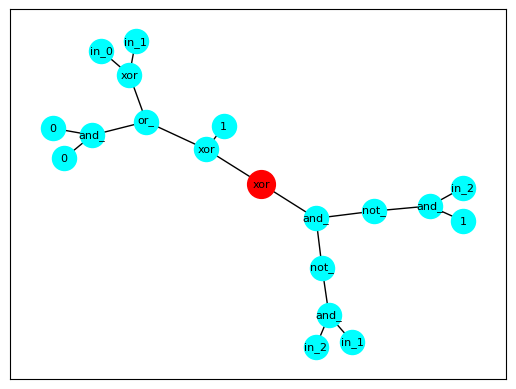

In [4]:
# Genetic Algorithm flow:
def main():
    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with elitism:
    population, logbook = elitism.eaSimpleWithElitism(population,
                                                      toolbox,
                                                      cxpb=P_CROSSOVER,
                                                      mutpb=P_MUTATION,
                                                      ngen=MAX_GENERATIONS,
                                                      stats=stats,
                                                      halloffame=hof,
                                                      verbose=True)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- length={}, height={}".format(len(best), best.height))
    print("-- Best Fitness = ", best.fitness.values[0])


    # plot best tree:
    nodes, edges, labels = gp.graph(best)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.spring_layout(g)

    nx.draw_networkx_nodes(g, pos, node_color='cyan')
    nx.draw_networkx_nodes(g, pos, nodelist=[0], node_color='red', node_size=400)

    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, **{"labels": labels, "font_size": 8})


    plt.show()


if __name__ == "__main__":
    main()